|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.1957   | 22.48     | 0.8606    | 15.18     | 3.033e+03 |
| 2         | -0.1666   | 12.86     | 0.2248    | 3.046     | 4.344e+03 |
| 3         | -0.1577   | 32.45     | 0.6665    | 2.371     | 4.853e+03 |
| 4         | -0.1654   | 42.63     | 0.2699    | 5.273     | 998.7     |
| 5         | -0.1741   | 19.39     | 0.5198    | 9.775     | 1.527e+03 |
| 6         | -0.1739   | 32.92     | 0.2116    | 7.259     | 1.895e+03 |
| 7         | -0.1621   | 26.07     | 0.7281    | 5.594     | 2.62e+03  |
| 8         | -0.206    | 32.07     | 0.1372    | 12.94     | 935.6     |
| 9         | -0.2053   | 8.862     | 0.8591    | 19.38     | 4.061e+03 |
| 10        | -0.2113   | 19.4      | 0.1781    | 14.32     | 2.257e+03 |
| 11        | -0.1602   | 11.37     | 0.4961    | 2.619     | 4.556e+03 |
| 12        | -0.1654   | 17.39     | 

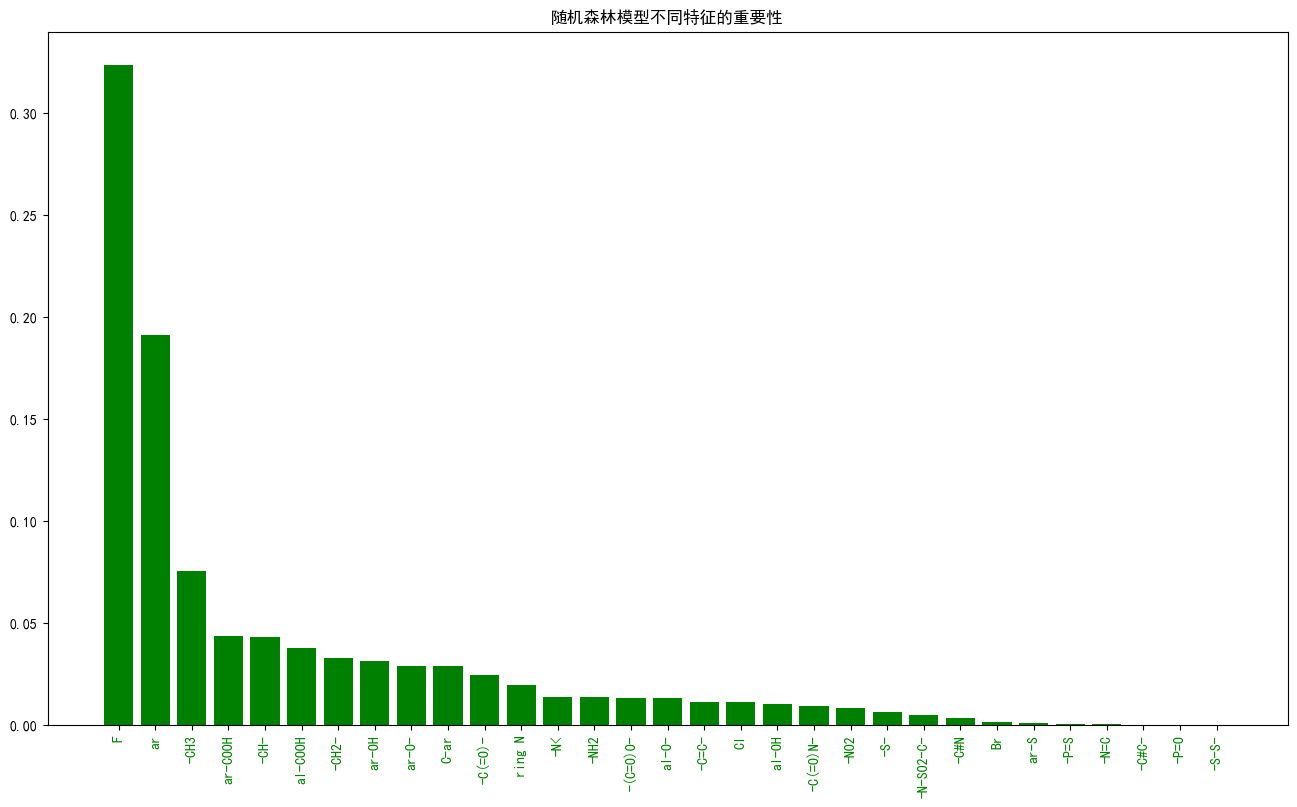

训练集的RMSE： 0.17022083572217572
训练集的平均R-squared： 0.9558493929176652
测试集的RMSE： 0.45573895669137543
测试集的R-squared： 0.69334191110094


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold

# 设置绘图大小和中文显示
plt.style.use({'figure.figsize': (16, 9)})
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或者选择其他字体
plt.rcParams['axes.unicode_minus'] = False

# 导入训练集和测试集
train_data = pd.read_excel(r'C:\Users\k\Desktop\硕士论文\ORP\ORP4\ORP_function_train.xlsx')
test_data = pd.read_excel(r'C:\Users\k\Desktop\硕士论文\ORP\ORP4\ORP_function_test.xlsx')

# 分离特征和目标变量
X_train, y_train = train_data.drop(['E','File'], axis=1), train_data['E']
X_test, y_test = test_data.drop(['E','File'], axis=1), test_data['E']

# 使用相同的random_state确保交叉验证的一致性
kf = KFold(n_splits=10, shuffle=True, random_state=99)

# Function to optimize (objective function for Bayesian optimization)
def rf_objective(n_estimators, max_depth, max_features, min_samples_split):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    min_samples_split = int(min_samples_split)

    rfg = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_split=min_samples_split,
        n_jobs=-1
    )

    mse_scores = cross_val_score(rfg, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = np.mean(mse_scores)
    
    return mean_mse

# Define the parameter bounds for Bayesian optimization
pbounds = {
    'n_estimators': (100, 5000),
    'max_depth': (6, 50),
    'max_features': (0.1, 0.9),
    'min_samples_split': (2, 20)
}

# Perform Bayesian optimization
rf_bo = BayesianOptimization(
    f=rf_objective,
    pbounds=pbounds,
    random_state=42
)

rf_bo.maximize(init_points=20, n_iter=40)

# Get the best hyperparameters
best_params = rf_bo.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])

print("Best Hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_rfg = RandomForestRegressor(**best_params, n_jobs=-1)
best_rfg.fit(X_train, y_train)

# 特征重要度分析
feature_importances = best_rfg.feature_importances_
indices = np.argsort(feature_importances)[::-1]

print('特征排序：')
feature_names = X_train.columns
for index in indices:
    print("feature %s (%f)" %(feature_names[index], feature_importances[index]))

plt.title("随机森林模型不同特征的重要性")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='g')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='g')
plt.xticks(rotation=90)
plt.show()

# 计算RMSE和R-squared（使用K折交叉验证结果）
RMSE_train = np.sqrt(mean_squared_error(y_train, best_rfg.predict(X_train)))
from sklearn.metrics import r2_score
# 计算测试集上的RMSE
RMSE_test = np.sqrt(mean_squared_error(y_test, best_rfg.predict(X_test)))

# 计算训练集上的R-squared
r_squared_train = r2_score(y_train, best_rfg.predict(X_train))

# 计算测试集上的R-squared
r_squared_test = r2_score(y_test, best_rfg.predict(X_test))


print("训练集的RMSE：", RMSE_train)
print("训练集的平均R-squared：", r_squared_train)

print("测试集的RMSE：", RMSE_test)
print("测试集的R-squared：", r_squared_test)

# 结果
submission = pd.DataFrame({"prediction": best_rfg.predict(X_test)})


In [7]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
# 计算MAPE
mape_train = mean_absolute_percentage_error(y_train,best_rfg.predict(X_train))
mape_test = mean_absolute_percentage_error(y_test, best_rfg.predict(X_test))
print(f'MAPE (Training): {mape_train}')
print(f'MAPE (Testing): {mape_test}')

MAPE (Training): 0.0654082115119874
MAPE (Testing): 0.17411142734188018


In [8]:
from sklearn.model_selection import cross_val_score
import numpy as np


kf1 = KFold(n_splits=10, shuffle=True, random_state=99)
# 执行5次交叉验证
mse_scores = cross_val_score(best_rfg, X_train, y_train, scoring='neg_mean_squared_error', cv=kf1)

# 将负MSE转换为RMSE
rmse_scores = np.sqrt(-mse_scores)

# 输出每次交叉验证的RMSE
print("10次交叉验证的RMSE：", rmse_scores)

# 输出5次交叉验证的平均RMSE
print("平均RMSE：", np.mean(rmse_scores))


10次交叉验证的RMSE： [0.39513962 0.41088642 0.53340218 0.42691935 0.43543954 0.23577009
 0.41588044 0.29049706 0.33960699 0.40087819]
平均RMSE： 0.38844198791605483
